# Enrichment Analysis on LCI Predictions

Analyzes the enrichment of proteins predicted by LCI

In [129]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import matplotlib.pyplot as plt 
import torch
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import goatools
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy


from dpp.methods.lci.lci_method import LCIModule
from dpp.data.network import PPINetwork
from dpp.util import Params, prepare_sns
from dpp.data.associations import load_diseases

prepare_sns(sns, None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data
Load disease associations and protein-protein interaction network.

In [2]:
# load diseases
diseases_dict = load_diseases("../data/associations/disgenet-associations.csv", exclude_splits=['none'])

In [3]:
# load network
network = PPINetwork("../data/networks/bio-pathways-network.txt")
n = len(network)

## Load Predictions
Load predictions from a disease protein prediction method.

In [4]:
predictions= pd.read_csv("../experiments/bio-pathways/dpp_predict/lci/predictions.csv", index_col=0)

## Load Enrichment Analysis
Prepare an enrichment study

In [5]:
# load gene ontology
obodag = GODag("../data/go/go-basic.obo")

../data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms


In [6]:
geneid2go = read_ncbi_gene2go("../data/go/gene2go.txt", taxids=[9606])

  20,385 items READ: ../data/go/gene2go.txt


In [7]:
goeaobj = GOEnrichmentStudy(network.get_proteins(), # List of mouse protein-coding genes
                            geneid2go, # geneid/GO associations
                            obodag, # Ontologies
                            propagate_counts = True,
                            alpha = 0.05, # default significance cut-off
                            methods = ['fdr_bh']) # defult multipletest correction method

fisher module not installed.  Falling back on scipy.stats.fisher_exact


Propagating term counts to parents ..


 76% 16,420 of 21,557 population items found in association


## Perform Enrichment Analysis
Perform an enrichment analysis on one disease. 

In [15]:
disease_id = "C1862314"

In [16]:
# run disease enrichment
disease_proteins = set(diseases_dict[disease_id].proteins)
disease_results = goeaobj.run_study(disease_proteins)

100%     23 of     23 study items found in association
100%     23 of     23 study items found in population(21557)
Calculating 21,968 uncorrected p-values using fisher_scipy_stats
  21,968 GO terms are associated with 16,420 of 21,557 population items
   1,564 GO terms are associated with     23 of     23 study items
     334 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh


In [18]:
# run prediction enrichment
pred_proteins = set(map(int, predictions.loc[disease_id].sort_values(ascending=False).index[:len(disease_proteins)]))
pred_results = goeaobj.run_study(pred_proteins)

 78%     18 of     23 study items found in association
100%     23 of     23 study items found in population(21557)
Calculating 21,968 uncorrected p-values using fisher_scipy_stats
  21,968 GO terms are associated with 16,420 of 21,557 population items
   1,263 GO terms are associated with     18 of     23 study items
     257 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh


In [19]:
k = 10
disease_top_k = sorted(disease_results, key=lambda x: x.p_fdr_bh)[:k]
disease_significant = [r for r in disease_results if r.p_fdr_bh < 0.05]

pred_top_k = sorted(pred_results, key=lambda x: x.p_fdr_bh)[:k]
pred_significant = [r for r in pred_results if r.p_fdr_bh < 0.05]

In [23]:
intersection = set([result.goterm.name for result in disease_top_k]) & set([result.goterm.name for result in pred_top_k])
union = set([result.goterm.name for result in disease_top_k]) | set([result.goterm.name for result in pred_top_k])

print("Jaccard Similarity: {}".format(1.0*len(intersection)/len(union)))

Jaccard Similarity: 0.25


In [22]:
intersection = set([result.goterm.name for result in pred_significant]) & set([result.goterm.name for result in disease_significant])
union = set([result.goterm.name for result in pred_significant]) | set([result.goterm.name for result in disease_significant])

print("Jaccard Similarity: {}".format(1.0*len(intersection)/len(union)))

Jaccard Similarity: 0.26282051282051283


## Load Enrichment Results
Load enrichment study results

In [77]:
lci_results = pd.read_csv("../experiments/go_enrichment/lci/results.csv", index_col=0)
rw_results = pd.read_csv("../experiments/go_enrichment/random_walk/results.csv", index_col=0)

In [81]:
lci_eval_results = pd.read_csv("../experiments/dpp_evaluate/lci/metrics.csv", index_col=0)

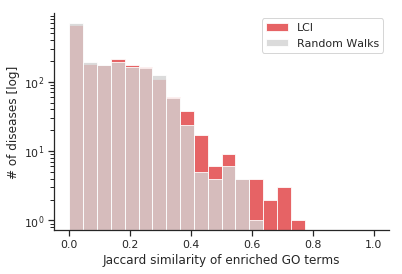

In [125]:
sns.distplot(lci_results["lci_jaccard_sim"], bins=22, kde=False, label="LCI", hist_kws={"range": (0, 1),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(rw_results["lci_jaccard_sim"], bins=22, kde=False, label="Random Walks", hist_kws={"range": (0, 1),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('log')
plt.xlabel("Jaccard similarity of enriched GO terms")
plt.ylabel("# of diseases [log]")
plt.legend()

In [86]:
lci_jaccard = lci_results["lci_jaccard_sim"].sort_index()

In [127]:
lci_dpp = lci_eval_results["Recall-at-100"].sort_index()

(0.2313963617379347, 1.9381489592385145e-23)

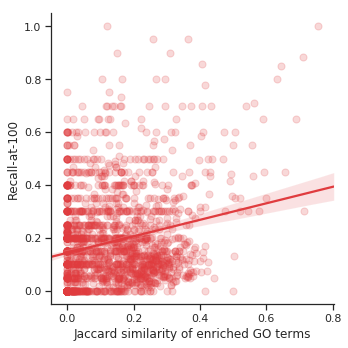

In [130]:
sns.lmplot(x='lci_jaccard_sim', y='Recall-at-100', data=pd.concat([lci_jaccard, lci_dpp], axis=1), scatter_kws={"s": 50, "alpha": 0.2})
plt.xlabel("Jaccard similarity of enriched GO terms")
plt.ylabel("Recall-at-100")



pearsonr(lci_jaccard, lci_dpp)